In [1]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import seaborn as sns
import mglearn
import numpy as np
import matplotlib.pyplot as plt

## 2) Создайте свой «мешок слов», например, набор из 20-25 отзывов о чем-либо, напишите краткое пояснение к данным.

In [2]:
# Загрузка отзывов
reviews_train = load_files('reviews/train/')
reviews_test = load_files('reviews/test/')


text_test = reviews_test.data
text_train = reviews_train.data

y_test, y_train = reviews_test.target, reviews_train.target

print('Тип текстового набора для обучения: \n{}'.format(type(text_train)))
print('Количество текстов в наборе для обучения: \n{}'.format(len(text_train)))
print('Пример текста из обучающего набора:\n{}'.format(text_train[1]))
print("Количество примеров в каждом классе (обучение): {}".format(np.bincount(y_train)))

Тип текстового набора для обучения: 
<class 'list'>
Количество текстов в наборе для обучения: 
20
Пример текста из обучающего набора:
b"The lives of these characters are overlydramatic and boring. They waste their energy on pensive talks to help the protagonist, who in every way, is a complete screw up. Sometimes it's funny when I see a groundhog go into a hole in a business suite but it gets ruined by mundane dialogue. They could have had so much fun with this show and made it less depressing. The news couple was the best part of this season."
Количество примеров в каждом классе (обучение): [10 10]


## 3) Создание мешка слов и применение стоп слов 

In [3]:
# vect = CountVectorizer(min_df=3, stop_words="english").fit(text_train)
vect = CountVectorizer(stop_words="english").fit(text_train)
X_train = vect.transform(text_train)

print('Размерность мешка слов: {}'.format(X_train.shape))

Размерность мешка слов: (20, 1113)


## Информация о признаках

In [4]:
feature_names = vect.get_feature_names_out()

# Выводим информацию о признаках
print("Общее количество признаков: {}".format(len(feature_names)))
print("Первые 20 признаков:\n {}".format(feature_names[:20]))
print("Каждый 25-й признак:\n {}".format(feature_names[::25]))
print("Последние 20 признаков:\n {}".format(feature_names[-20:]))

Общее количество признаков: 1113
Первые 20 признаков:
 ['10' '100' '15' '18' '2d' '90' '90s' 'aaron' 'absurd' 'absurdist'
 'abusive' 'acceptance' 'accurate' 'achieve' 'achievement' 'achieves'
 'achieving' 'act' 'acted' 'acting']
Каждый 25-й признак:
 ['10' 'actually' 'anti' 'backseat' 'binging' 'break' 'cartoon' 'circle'
 'cons' 'criticism' 'delighted' 'dimensional' 'earlier' 'entertainment'
 'exception' 'father' 'following' 'geniuses' 'guarantee' 'help' 'humans'
 'inconsistent' 'issues' 'leave' 'looked' 'mask' 'mission' 'need' 'oh'
 'paul' 'plenty' 'pretty' 'question' 'reinforce' 'rolling' 'schaaf'
 'showbusiness' 'spoof' 'struggle' 'sure' 'thinks' 'tried' 'used'
 'warrant' 'worst']
Последние 20 признаков:
 ['wonderful' 'wonderfully' 'words' 'work' 'works' 'world' 'worship'
 'worst' 'worth' 'wow' 'wrapped' 'write' 'writers' 'writing' 'written'
 'wrong' 'wrote' 'year' 'years' 'yes']


## 4) Масштабируйте данные с помощью tf-idf

In [5]:
pipe = make_pipeline(TfidfVectorizer(norm=None), LogisticRegression())

# Параметры
param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__max_iter': [10000, 20000, 30000],
    'logisticregression__solver': ['liblinear', 'saga'],
    'tfidfvectorizer__ngram_range': [(1,1), (1,2), (1,3)],
}

grid = GridSearchCV(pipe, param_grid, cv=4)
grid.fit(text_train, y_train)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(norm=None)),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1, 10,
                                                   100],
                         'logisticregression__max_iter': [10000, 20000, 30000],
                         'logisticregression__solver': ['liblinear', 'saga'],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3)]})

In [60]:
print('Лучший результат: {:.2f} '.format(grid.best_score_))
print('Лучшие параметры: {}'.format(grid.best_params_))

Лучший результат: 0.75 
Лучшие параметры: {'logisticregression__C': 0.01, 'logisticregression__max_iter': 10000, 'logisticregression__solver': 'liblinear', 'tfidfvectorizer__ngram_range': (1, 2)}


#### 5) Исследуйте коэффициенты модели

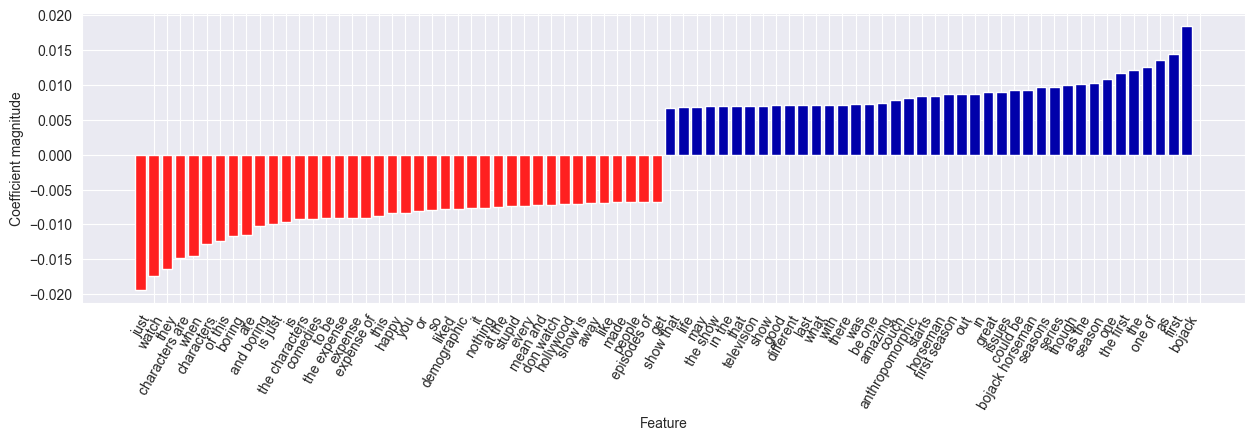

<Figure size 1500x500 with 0 Axes>

In [61]:
# 40 наибольших и 40 наименьших коэффициентов

vectorizer = grid.best_estimator_.named_steps['tfidfvectorizer']

feature_names = np.array(vectorizer.get_feature_names_out())

coefficients = grid.best_estimator_.named_steps['logisticregression'].coef_[0]

mglearn.tools.visualize_coefficients(coefficients, feature_names, n_top_features=40)

plt.figure(figsize=(15, 5))
plt.show()

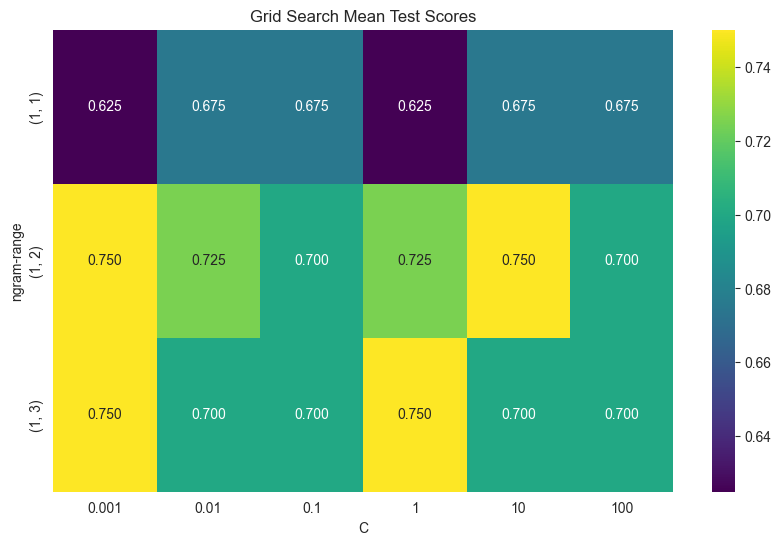

In [62]:
#Теплокарта

scores = grid.cv_results_['mean_test_score'].reshape(
    len(param_grid['tfidfvectorizer__ngram_range']),
    -1,
    len(param_grid['logisticregression__C'])
)

mean_scores = scores.mean(axis=1)

plt.figure(figsize=(10, 6))
sns.heatmap(mean_scores, annot=True, fmt=".3f", cmap='viridis', 
            xticklabels=param_grid['logisticregression__C'],
            yticklabels=param_grid['tfidfvectorizer__ngram_range'])
plt.xlabel('C')
plt.ylabel('ngram-range')
plt.title('Grid Search Mean Test Scores')
plt.show()

In [63]:
#Отчет

prediction = grid.best_estimator_.predict(text_test)

print(classification_report(y_test, prediction, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.50      0.67         2

    accuracy                           0.80         5
   macro avg       0.88      0.75      0.76         5
weighted avg       0.85      0.80      0.78         5


## 6) Сделайте выводы по работе.

Модель показывает хорошую точность, то говорит о её способности достаточно точно классифицировать объекты. Общая точность модели составляет 80%, что представляет собой долю правильных предсказаний по всем классам. Макроусредненная и взвешенная F1-мера также предоставляют общую картину оценки модели, их значения говорят о неплохой эффективности модели на всем наборе данных.